# Models

In [23]:
import pandas as pd
from catboost import CatBoostRegressor
from matplotlib import pyplot as plt
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from xgboost import XGBRegressor

X_train = pd.read_csv('dataset_processed/X_train_processed.csv')
X_test = pd.read_csv('dataset_processed/X_test_processed.csv')

original_data = pd.read_csv('Car details v3.csv')
y = original_data['selling_price']

_, _, y_train, y_test = train_test_split(original_data, y, test_size=0.3, random_state=42)

-------------------
#### CatBoost

-------------------

In [3]:
model = CatBoostRegressor(
    eval_metric='RMSE',
    random_seed=42,
    verbose=0
)

param_grid = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7],
    'bagging_temperature': [0, 0.5, 1]
}

catboost = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1,
    random_state=42
)

catboost.fit(X_train, y_train)

y_pred_catboost = catboost.predict(X_test)

metrics_catboost = {
    "name": "CatBoost",
    "MAE_training": mean_absolute_error(y_train, catboost.predict(X_train)),
    "MAE": mean_absolute_error(y_test, y_pred_catboost),
    "RMSE": root_mean_squared_error(y_test, y_pred_catboost),
    "MAPE": mean_absolute_percentage_error(y_test, y_pred_catboost),
    "R2": r2_score(y_test, y_pred_catboost)
}

Fitting 5 folds for each of 50 candidates, totalling 250 fits


-------------------
#### Random Forest

-------------------

In [10]:
model = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 20, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False]
}

random_forest = RandomizedSearchCV(
    estimator=model,
    n_iter=50,
    param_distributions=param_dist,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_mean_squared_error'
)

random_forest.fit(X_train, y_train)

y_pred_random_forest = random_forest.predict(X_test)

metrics_rf = {
    "name": "Random Forest",
    "MAE_training": mean_absolute_error(y_train, random_forest.predict(X_train)),
    "MAE": mean_absolute_error(y_test, y_pred_random_forest),
    "RMSE": root_mean_squared_error(y_test, y_pred_random_forest),
    "MAPE": mean_absolute_percentage_error(y_test, y_pred_random_forest),
    "R2": r2_score(y_test, y_pred_random_forest)
}

-------------------
#### XGBoost

-------------------

In [21]:
model = XGBRegressor(random_state=42)

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(1, 2)
}

xgb = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

metrics_xgb = {
    "name": "XGBoost",
    "MAE_training": mean_absolute_error(y_train, xgb.predict(X_train)),
    "MAE": mean_absolute_error(y_test, y_pred_xgb),
    "RMSE": root_mean_squared_error(y_test, y_pred_xgb),
    "MAPE": mean_absolute_percentage_error(y_test, y_pred_xgb),
    "R2": r2_score(y_test, y_pred_xgb)
}

In [22]:
metrics = pd.DataFrame([metrics_rf, metrics_catboost, metrics_xgb])
metrics.sort_values(by=['MAE'], ascending=True)

,name,MAE_training,MAE,RMSE,MAPE,R2
2,XGBoost,26909.630227,67414.039076,171331.011660,0.146277,0.957387
1,CatBoost,44059.279591,69164.659476,174297.515275,0.150360,0.955899
0,Random Forest,27065.967252,70647.200319,171130.379237,0.153345,0.957487


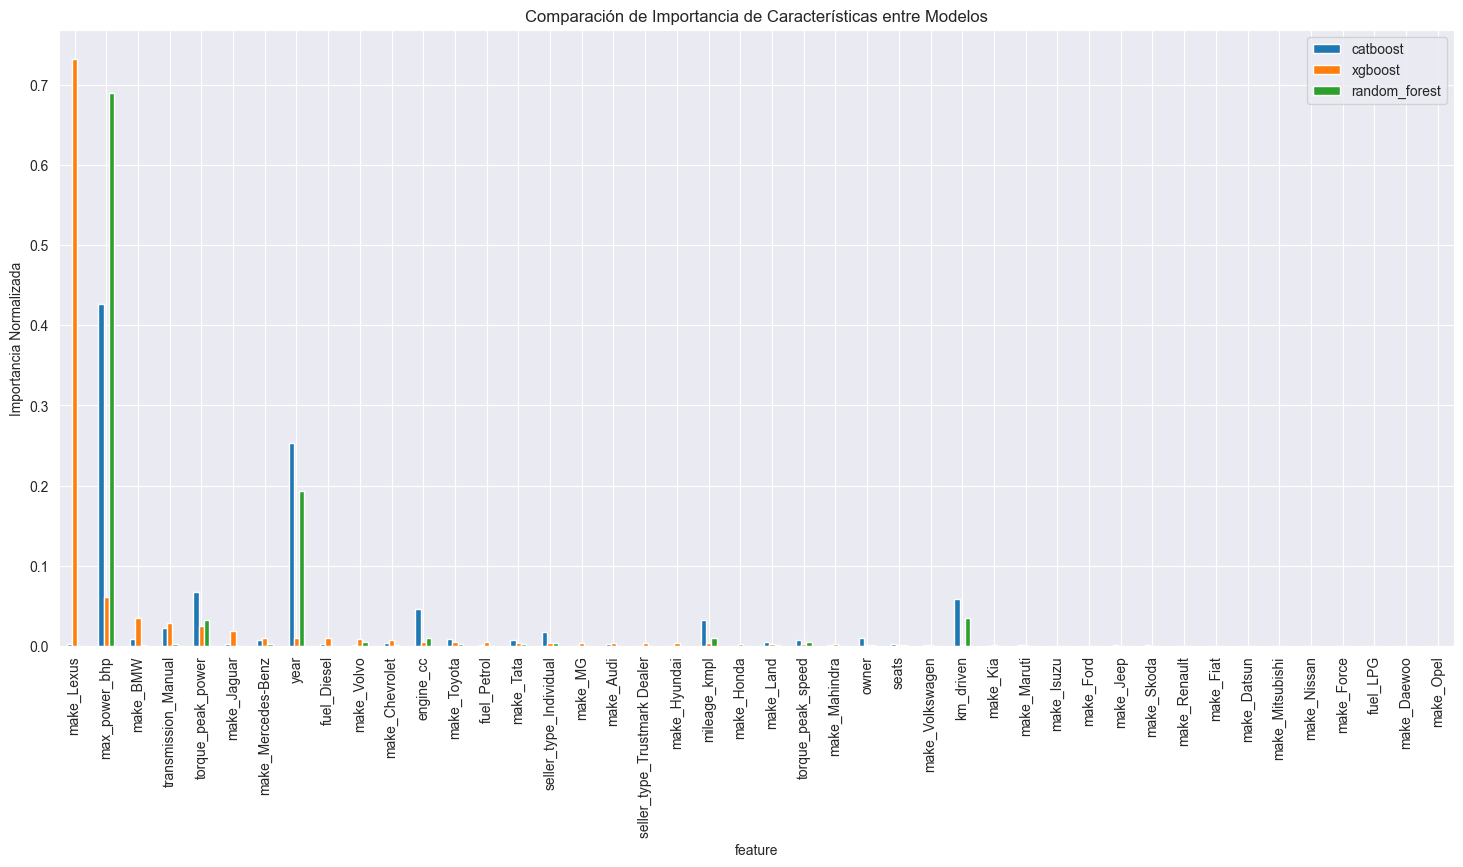

In [33]:
catboost_best = catboost.best_estimator_
xgboost_best = xgb.best_estimator_
rf_best = random_forest.best_estimator_

catboost_importances = catboost_best.get_feature_importance()
xgboost_importances = xgboost_best.feature_importances_
rf_importances = rf_best.feature_importances_

features = X_train.columns
importance_df = pd.DataFrame({
    'feature': features,
    'catboost': catboost_importances,
    'xgboost': xgboost_importances,
    'random_forest': rf_importances
})

importance_df['catboost'] /= importance_df['catboost'].sum()
importance_df['xgboost'] /= importance_df['xgboost'].sum()
importance_df['random_forest'] /= importance_df['random_forest'].sum()

importance_df = importance_df.sort_values(by='xgboost', ascending=False)

importance_df.plot(x='feature', kind='bar', figsize=(18, 8),
                   title="Comparación de Importancia de Características entre Modelos")
plt.xticks(rotation=90)
plt.ylabel("Importancia Normalizada")
plt.show()


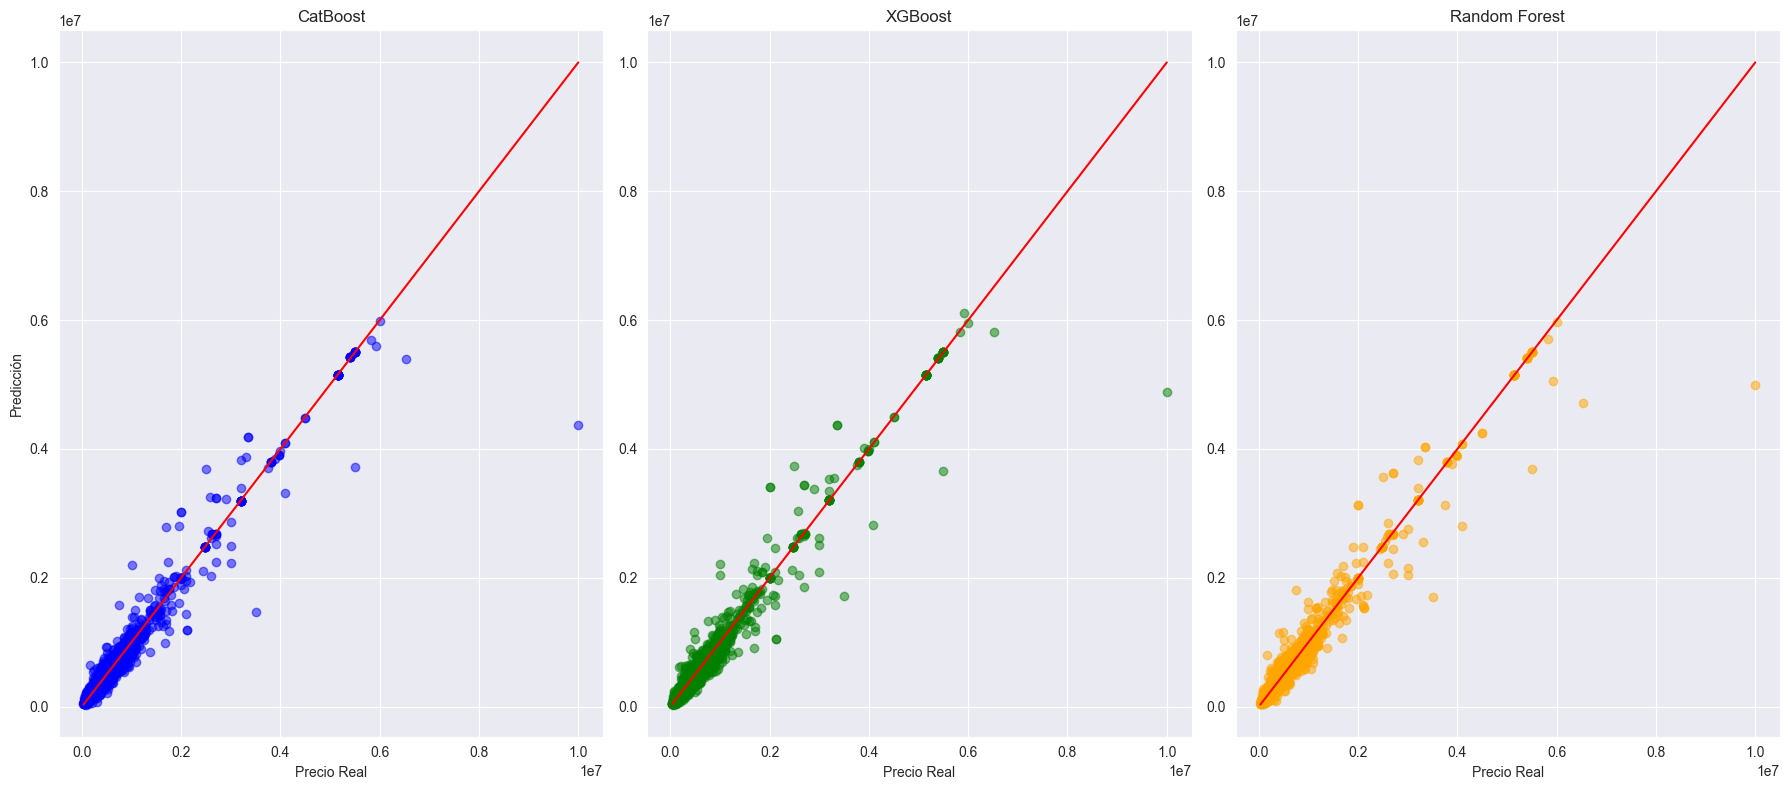

In [36]:
y_pred_catboost = catboost_best.predict(X_test)
y_pred_xgboost = xgboost_best.predict(X_test)
y_pred_rf = rf_best.predict(X_test)

plt.figure(figsize=(18, 8))

plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_catboost, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.title("CatBoost")
plt.xlabel("Precio Real")
plt.ylabel("Predicción")

plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_xgboost, alpha=0.5, color='green')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.title("XGBoost")
plt.xlabel("Precio Real")

plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='orange')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.title("Random Forest")
plt.xlabel("Precio Real")

plt.tight_layout()
plt.show()
